## Skorch GA network classification example

In [1]:
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.ga_nn import GAModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math
import random

cancer_data = load_breast_cancer()
X, cancer_test, y, cancer_test_label = train_test_split(cancer_data.data, cancer_data.target, test_size=0.2, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)
cancer_test = cancer_test.astype(np.float32)
cancer_test_label = cancer_test_label.astype(np.int64)


In [20]:
from skorch.callbacks import EpochScoring 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# best score: 0.958, best params: {'net__max_epochs': 1000, 'net__module__input_dim': 30, 'net__module__mate_pct': 0.8, 'net__module__mutate_pct': 0.8, 'net__module__output_dim': 2, 'net__module__population_size': 50}
net = NeuralNetClassifier(
    module=GAModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=20,
    module__hidden_layers=2,
    module__population_size=50,
    module__mate_pct=.8,
    module__mutate_pct=.8,
    max_epochs=1000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # use nn.CrossEntropyLoss instead of default nn.NLLLoss
    # for use with raw prediction values instead of log probabilities
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
GAModule.register_ga_training_step()

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])
pipe.fit(X, y)

Pipeline(steps=[('scale', StandardScaler()),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=GAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=30, out_features=20, bias=True)
      (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
      (3): Linear(in_features=20, out_features=2, bias=True)
    )
  ),
))])

In [21]:
np.mean(pipe.predict(cancer_test) == cancer_test_label)

0.9649122807017544

## Plot learning curves

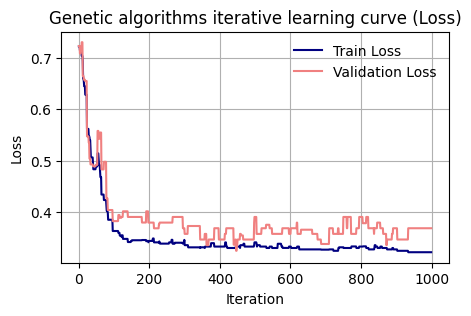

In [26]:
# plot the iterative learning curve (loss)
plt.figure(figsize=(5,3))
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Genetic algorithms iterative learning curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.savefig('out/ga_it_loss.png')

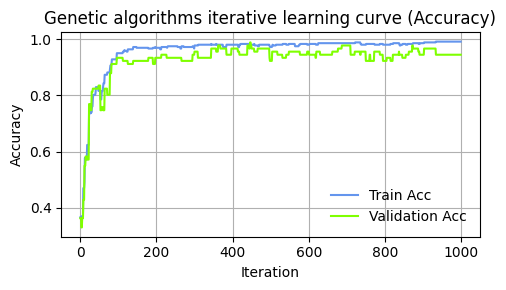

In [27]:
# plot the iterative learning curve (accuracy)
plt.figure(figsize=(5,3))
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Genetic algorithms iterative learning curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('out/ga_it_acc.png')

/var/folders/7p/vzwbxqxj5l34ybqxm5zx9yzm0000gn/T/ipykernel_83419/1641090582.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


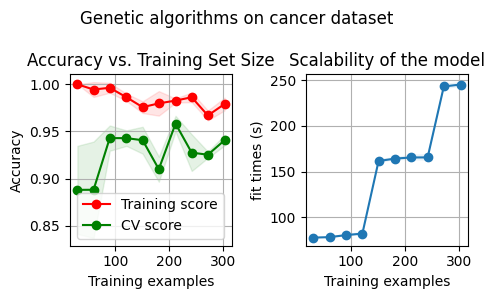

In [9]:
def learningCurvePlots(model, X, y, modelName, dataName, extraName=""):
    np.random.seed(0)
    # make the learning curve for the cancer data with a decision tree
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        model, 
        X, 
        y, 
        train_sizes=np.linspace(0.1, 1.0, 10), 
        cv=3,
        return_times=True,
        shuffle=True,
        random_state=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    fig = plt.figure(figsize=(5,3))
    ax1 = fig.add_subplot(1, 2, 1)
    # plot the training score and cross validation score
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV score")
    ax1.grid()
    ax1.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax1.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax1.legend(loc="best")
    ax1.set_xlabel("Training examples")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(f"Accuracy vs. Training Set Size")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.grid()
    ax2.plot(train_sizes, fit_times_mean, "o-")
    ax2.fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    ax2.set_xlabel("Training examples")
    ax2.set_ylabel("fit times (s)")
    ax2.set_title(f"Scalability of the model")

    # set a title for the figure
    if extraName:
        extraName = f" ({extraName})"
    fig.suptitle(f"{modelName} on {dataName} dataset{extraName}")
    fig.tight_layout()
    filteredModelName = modelName.replace(" ", "_")
    filteredDataName = dataName.replace(" ", "_")
    fig.savefig(f"out/{filteredModelName}_{filteredDataName}_learning_curve.png")
    fig.show()

learningCurvePlots(pipe, X, y, "Genetic algorithms", "cancer", extraName="")

## grid search

In [3]:
from sklearn.model_selection import GridSearchCV
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

default_params = {
    'net__module__input_dim': [30],
    'net__module__output_dim': [2],
    'net__max_epochs': [250, 500, 1000],
    'net__module__population_size': [20, 50, 100],
    'net__module__mate_pct': [.2, .5, .8],
    'net__module__mutate_pct': [.5, .8],
}

grid_search_params = {
    # 'net__to_mutate': [30, 60],
    **default_params,
}

gs = GridSearchCV(pipe, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.5, net__module__output_dim=2, net__module__population_size=20; total time=  24.2s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.5, net__module__output_dim=2, net__module__population_size=20; total time=  23.1s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.5, net__module__output_dim=2, net__module__population_size=20; total time=  23.2s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.5, net__module__output_dim=2, net__module__population_size=50; total time=  53.9s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.5, net__module__output_dim=2, net__module__population_size=5